Michael Muschitiello // AI in Asset Management 

- This project draws on the methodology presented by Ren Raw Chen and Xiaohu Zheng in From Liquidity Risk to Systemic Risk: A Use of Knowledge Graph. However, rather than focusing on liquidity and systemic risk, the goal here is to visualize conditional dependencies among rolling volatilities in a basket of stocks across three distinct timeframes: before, during, and after the COVID-19 pandemic market shocks. To achieve this, we employ GraphicalLasso, GraphicalLassoCV, and KNN machine learning algorithms to build knowledge graphs for each of these periods. These graphs offer insights into how the relationships among stock volatilities evolve in response to major market stress events. 

In [1]:
import numpy as np 
import pandas as pd 
import yfinance as yf 
from sklearn.covariance import GraphicalLasso
from sklearn.covariance import GraphicalLassoCV
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import networkx as nx
import matplotlib.pyplot as plt 
import seaborn as sns 

### Downloading Price data for 28 stocks

In [2]:
tickers = ['AAPL', 'NVDA', 'MSFT', 'AMZN', 'META', 'GOOGL', 'TSLA', 'AVGO', 'GOOG', 'BRK-B', 
           'JPM', 'LLY', 'V', 'UNH', 'XOM', 'COST', 'JNJ', 'ABBV', 'ORCL', 'HD', 'CVX', 'KO',
           'SBUX', 'GE', 'MRK', 'MCD', 'GS', 'PEP']
len(tickers)

28

In [3]:
start = '2017-01-01'
end = '2025-02-01'

stock_data = pd.DataFrame()
for ticker in tickers:
    data = yf.download(ticker, start=start, end=end, interval = '1d')
    close_data = data['Close']
    stock_data = pd.concat([stock_data, close_data], axis=1)

    

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

### Daily Returns

In [4]:
nan_counts = stock_data.isna().sum()
nan_counts 

Ticker
AAPL     0
NVDA     0
MSFT     0
AMZN     0
META     0
GOOGL    0
TSLA     0
AVGO     0
GOOG     0
BRK-B    0
JPM      0
LLY      0
V        0
UNH      0
XOM      0
COST     0
JNJ      0
ABBV     0
ORCL     0
HD       0
CVX      0
KO       0
SBUX     0
GE       0
MRK      0
MCD      0
GS       0
PEP      0
dtype: int64

In [5]:
stock_rets = stock_data.pct_change().dropna()

### Calculating a rolling 252-day volatility for each stocks returns

<Axes: title={'center': 'Rolling 1-Year Volatility of Stocks'}, xlabel='Date'>

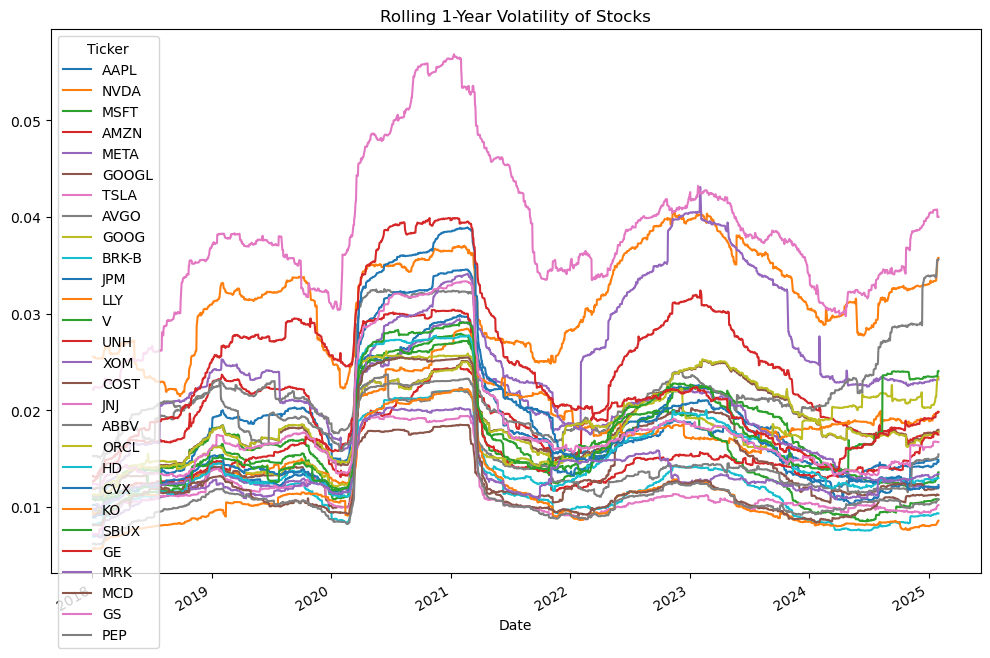

In [6]:
rolling_vol = stock_rets.rolling(window=252).std().dropna()
rolling_vol.plot(figsize=(12, 8), title='Rolling 1-Year Volatility of Stocks')

Making 3 separate dfs for each respective time period:

- 2/2018-2/2020
- 2/2020-2/2022
- 2/2022-2/2025

In [8]:
# creating dateranges
date_range1 = ('2018-01-01', '2020-01-01')
date_range2 = ('2020-01-01', '2022-01-01')
date_range3 = ('2022-01-01', '2025-01-01')

# creating dataframes for each period
p1_vol = rolling_vol.loc[date_range1[0]:date_range1[1]]
p2_vol = rolling_vol.loc[date_range2[0]:date_range2[1]]
p3_vol = rolling_vol.loc[date_range3[0]:date_range3[1]]


### Computing Correlation Matrices of the 252-day Rolling Volatilities

In [9]:
dfs = [p1_vol, p2_vol, p3_vol]
correlation_matrices = []

for i, df in enumerate(dfs):
    corr_matrix = df.corr()
    correlation_matrices.append(corr_matrix)
    print(f"Correlation Matrix for DataFrame {i+1}:")
    print(corr_matrix)
    print("\n")

Correlation Matrix for DataFrame 1:
Ticker      AAPL      NVDA      MSFT      AMZN      META     GOOGL      TSLA  \
Ticker                                                                         
AAPL    1.000000  0.880939  0.867231  0.921575  0.804197  0.935314  0.882228   
NVDA    0.880939  1.000000  0.696850  0.838693  0.566568  0.738001  0.705815   
MSFT    0.867231  0.696850  1.000000  0.949561  0.919282  0.964288  0.895903   
AMZN    0.921575  0.838693  0.949561  1.000000  0.886656  0.925347  0.916899   
META    0.804197  0.566568  0.919282  0.886656  1.000000  0.881980  0.943433   
GOOGL   0.935314  0.738001  0.964288  0.925347  0.881980  1.000000  0.897181   
TSLA    0.882228  0.705815  0.895903  0.916899  0.943433  0.897181  1.000000   
AVGO    0.875213  0.701758  0.945544  0.937225  0.959101  0.926879  0.952821   
GOOG    0.943687  0.753260  0.951635  0.916633  0.858337  0.998401  0.884018   
BRK-B   0.699558  0.513177  0.950518  0.858163  0.904918  0.866182  0.828620   
JPM 

### Applying GraphicalLASSO to detect any conditional independence

**using alpha=0.005**

- Graphical Lasso is used to estimate sparse precision matrices by imposing an l-1 penalty to identify the most relevant conditional dependencies while filtering out spurious connections caused by noise or common market-wide effects. During an economic shock in financial networks, stock correlations spike due to systemic factors, and GraphicalLASSO helps isolate direct relationships by removing indirect dependencies, making the knowledge graph more interpretable.

- the alpha parameter controls the strength of the L1-penalty applied to the precision matrix. It governs how strongly the algorithm pushes entries in the precision matrix toward zero

- Higher alpha -> More shrinkage
This imposes a stronger penalty on the off-diagonal elements of the precision matrix. This leads to a sparser graph with fewer edges, reflecting fewer direct conditional dependencies

- Lower alpha -> Less shrinkage
This imposes a weaker penalty. More off-diagonal elements remain non-zero, resulting in a denser graph with more edges.

- A good practice is to use GraphicalLassoCV which automatically finds an optimal alpha with cross validation

In [10]:
# check for any NaN values in the correlation matrices
nan_values = correlation_matrices[2].isna().sum().sum()
nan_values

0

In [11]:
# parameters for each matrix
params_list = [
    (0.005, 5000, 1e-3),   
    (0.005, 3000, 1e-3),   
    (0.005, 5000, 1e-3)   
]

precision_matrices = []

# Loop through each set of parameters and each correlation matrix
for i, (alpha, max_iter, tol) in enumerate(params_list):
    model = GraphicalLasso(alpha=alpha, max_iter=max_iter, tol=tol)
    model.fit(correlation_matrices[i])  # Fit to the i-th correlation matrix
    precision_matrices.append(model.precision_) 

c:\Users\musch\anaconda3\Lib\site-packages\sklearn\covariance\_graph_lasso.py:191: ConvergenceWarning: graphical_lasso: did not converge after 5000 iteration: dual gap: 9.141e-02
  warnings.warn(


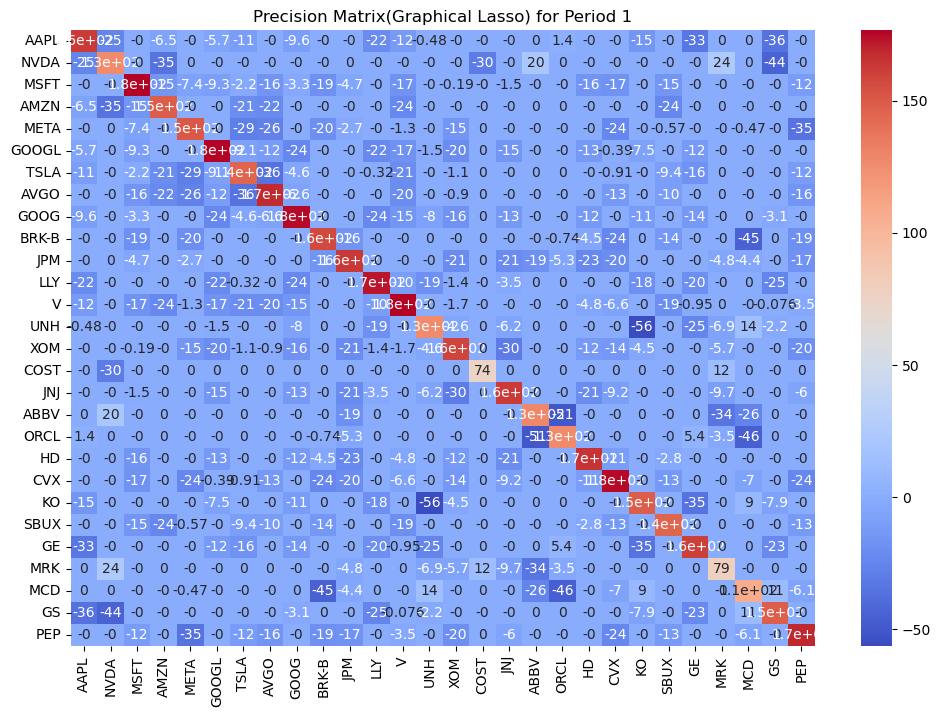

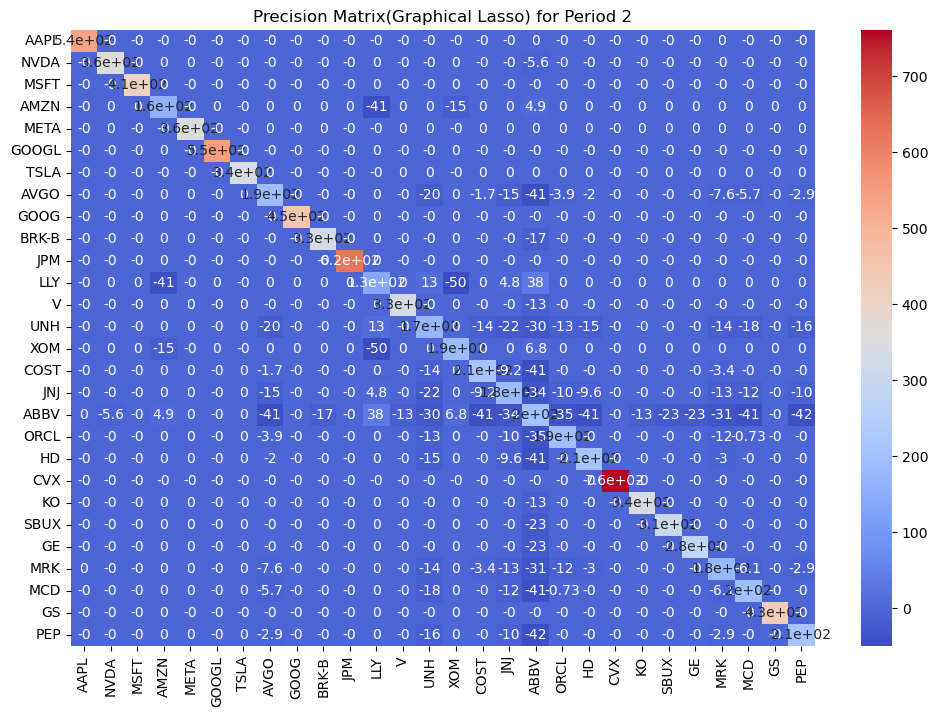

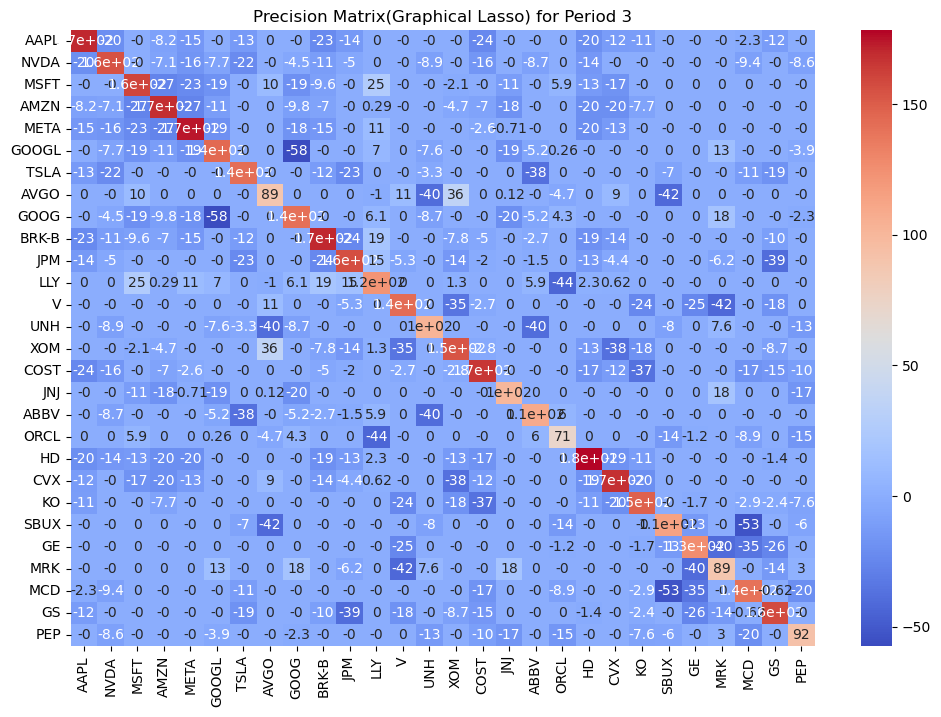

In [12]:
#prgbrsfdnmolk ,
#ecision_matrices = [precision_matrix1, precision_matrix2, precision_matrix3]

for i, dfs in enumerate(precision_matrices):
    plt.figure(figsize=(12, 8))
    sns.heatmap(dfs, cmap='coolwarm', xticklabels=rolling_vol.columns, yticklabels=rolling_vol.columns, annot=True)
    plt.title(f'Precision Matrix(Graphical Lasso) for Period {i+1}')
    plt.show()


### Generating the Knowledge Graph


In [13]:
col_names = p1_vol.columns

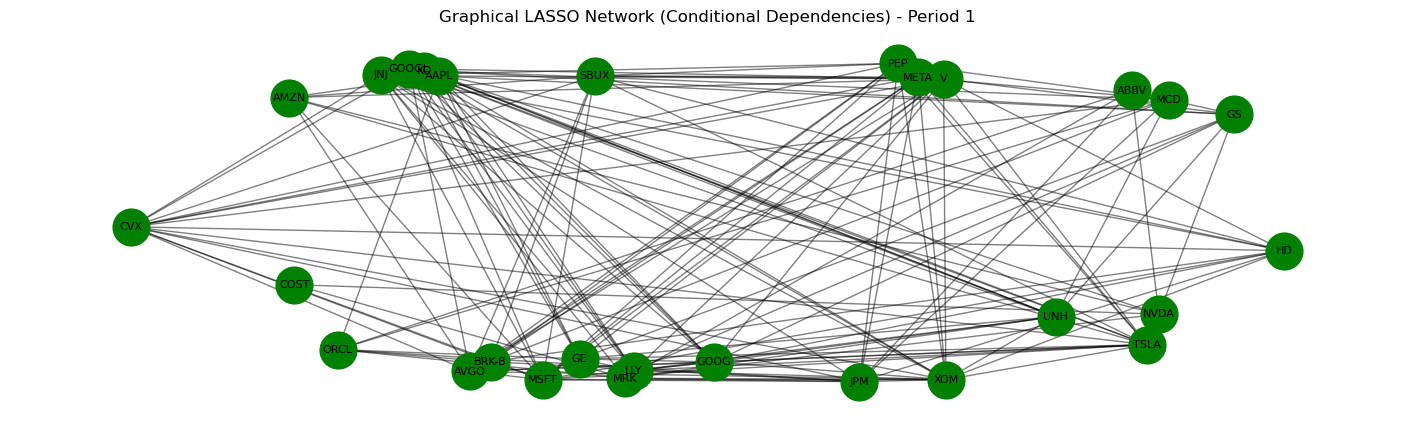

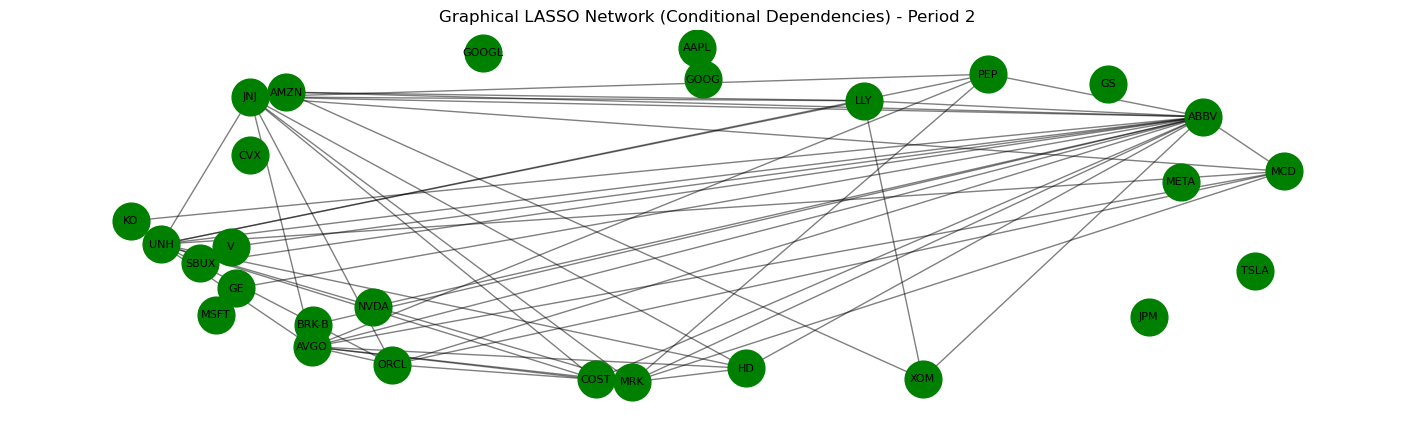

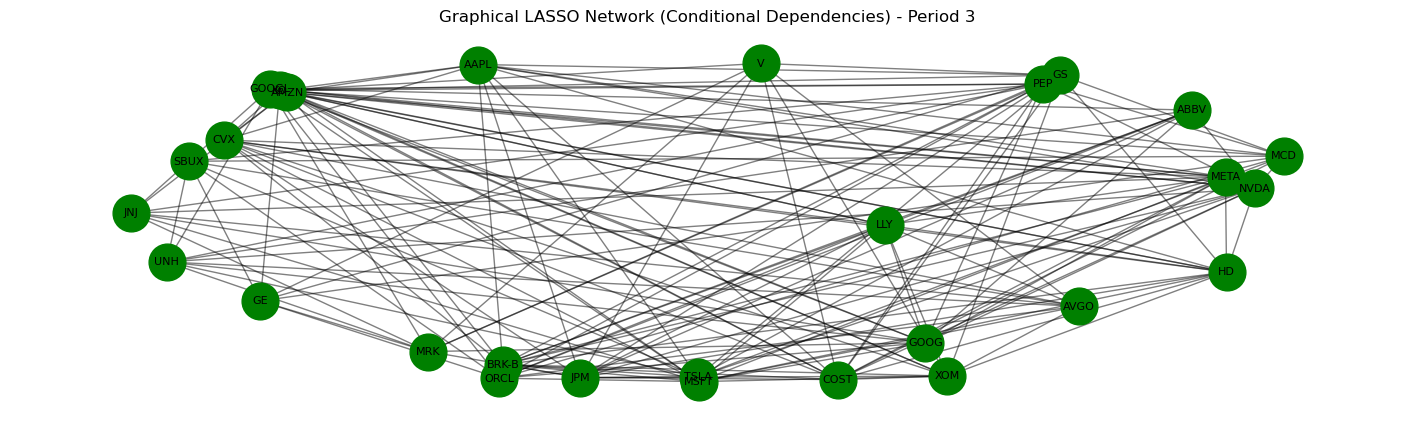

In [14]:
# using col_names as stock list
degrees_df = pd.DataFrame(index=col_names)

for i, pmatrix in enumerate(precision_matrices):
    pmatrix = pd.DataFrame(pmatrix, columns=col_names, index=col_names)
    G = nx.Graph()
    # add nodes
    for col in p1_vol.columns:
        G.add_node(col)
    # add edges
    for j in range(len(pmatrix.columns)):
        for k in range(j + 1, len(pmatrix.columns)):
            if pmatrix.iloc[j, k] != 0:
                G.add_edge(
                    pmatrix.columns[j],
                    pmatrix.columns[k],
                    weight=pmatrix.iloc[j, k]
                )
    # create graph
    plt.figure(figsize=(18, 5))
    pos = nx.spring_layout(G, seed=42)
    nx.draw_networkx_nodes(G, pos, node_size=700, node_color='green')
    nx.draw_networkx_edges(G, pos, width=1, alpha=0.5)
    nx.draw_networkx_labels(G, pos, font_size=8)
    plt.title(f"Graphical LASSO Network (Conditional Dependencies) - Period {i+1}")
    plt.axis("off")
    plt.show()

    # dict to store degree of each node, inserting into degrees_df
    degree_dict = dict(G.degree())
    degrees_ordered = [degree_dict[name] for name in col_names]
    degrees_df[f"Period {i+1} Degrees"] = degrees_ordered

In [15]:
degrees_df

,Period 1 Degrees,Period 2 Degrees,Period 3 Degrees
Ticker,,,
AAPL,12,0,12
NVDA,6,1,14
MSFT,15,0,12
AMZN,7,3,14
META,11,0,12
GOOGL,14,0,12
TSLA,14,0,9
AVGO,11,9,9
GOOG,14,0,12


In [30]:
degrees_GL = (degrees_df['Period 1 Degrees'].sum(), degrees_df['Period 2 Degrees'].sum(), degrees_df['Period 3 Degrees'].sum())
degrees_GL

(296, 100, 308)

In [16]:
# computing edges in each graph
# handshaking lemma: sum of degrees = 2 * number of edges
edge_count = pd.DataFrame({
    'Period 1': degrees_df['Period 1 Degrees'].sum() / 2,
    'Period 2': degrees_df['Period 2 Degrees'].sum() / 2,
    'Period 3': degrees_df['Period 3 Degrees'].sum() / 2
    }, index=['Edge Count'])

print(f"The Number of Edges in each Period's Graph:")
edge_count 

The Number of Edges in each Period's Graph:


,Period 1,Period 2,Period 3
Edge Count,148.0,50.0,154.0


## GraphicalLasso Cross Validation 

- Standardizing data
- Applying PCA
- Fit GraphicalLassoCV on PCA-transformed data
- Transform precision matric from PCA space back to original feature space

In [17]:
dfs = [p1_vol, p2_vol, p3_vol]

In [ ]:
precision_matrices_cv = []

for i, df in enumerate(dfs):
    # standardize the data
    scaler = StandardScaler()
    df_standardized = pd.DataFrame(
        scaler.fit_transform(df),
        index=df.index,
        columns=df.columns
    )
    
    # apply PCA
    #    n_components=0.995 retains enough components to explain 99.5% variance
    pca = PCA(n_components=0.995)
    X_pca = pca.fit_transform(df_standardized)  
    # X_pca now has shape (n_samples, n_principal_components)

    # fit GraphicalLassoCV directly on the pca-transformed data
    model = GraphicalLassoCV(
        cv=2,
        alphas=np.logspace(-2, 1, 20),
        max_iter=2000,
        tol=1e-3,
        n_jobs=-1
    )
    model.fit(X_pca) 

    # resulting precision_ is in the PCA space 
    precision_pca = model.precision_

    # transform precision matrix back to the original feature space
    # pca.components_ has shape (n_components, n_original_features)
    # Convert back by:  U^T * Precision_pca * U   where U = pca.components_.T
    precision_original = pca.components_.T @ precision_pca @ pca.components_

    # store results as a df
    precision_df = pd.DataFrame(
        precision_original,
        index=df.columns,
        columns=df.columns
    )
    precision_matrices_cv.append(precision_df)


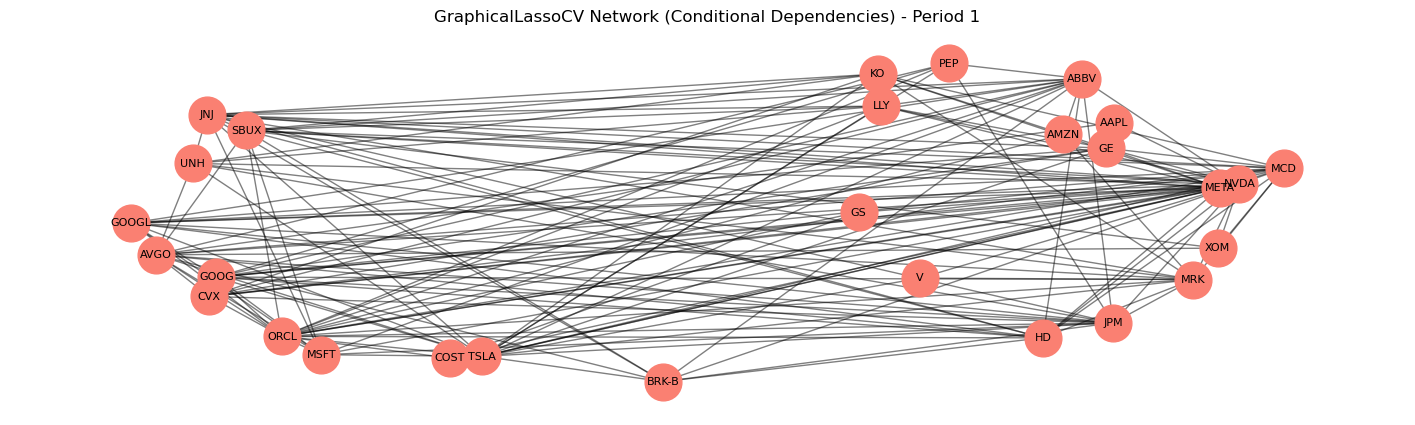

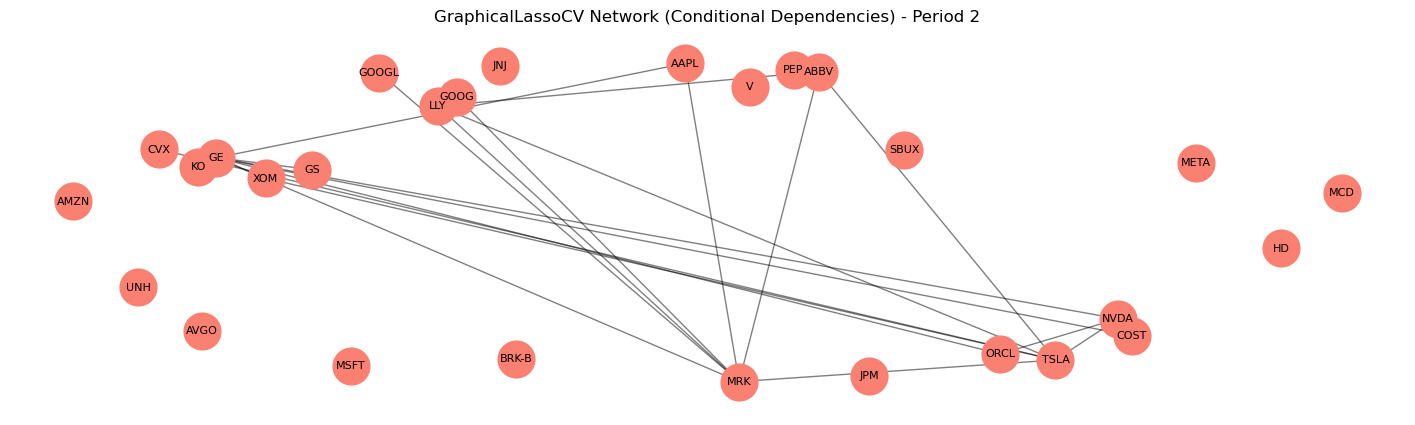

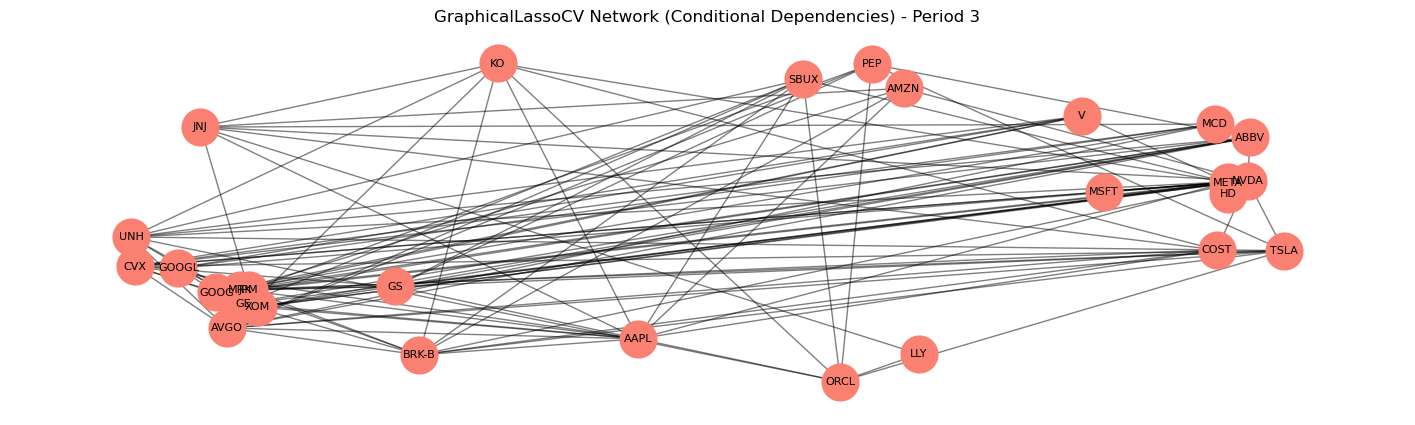

In [39]:
CVdegrees_df = pd.DataFrame(index=col_names)

threshold = 1.25  # threshold for edge inclusion

for i, pmatrix in enumerate(precision_matrices_cv):
    pmatrix = pd.DataFrame(pmatrix, columns=col_names, index=col_names)
    G = nx.Graph()

    # add nodes
    for col in pmatrix.columns:
        G.add_node(col)

    # add edges if abs(weight) above threshold
    for j in range(len(pmatrix.columns)):
        for k in range(j + 1, len(pmatrix.columns)):
            if abs(pmatrix.iloc[j, k]) > threshold:
                G.add_edge(
                    pmatrix.columns[j],
                    pmatrix.columns[k],
                    weight=pmatrix.iloc[j, k]
                )

    plt.figure(figsize=(18, 5))
    pos = nx.spring_layout(G, seed=42)
    nx.draw_networkx_nodes(G, pos, node_size=700, node_color='salmon')
    nx.draw_networkx_edges(G, pos, width=1, alpha=0.5)
    nx.draw_networkx_labels(G, pos, font_size=8)
    plt.title(f"GraphicalLassoCV Network (Conditional Dependencies) - Period {i+1}")
    plt.axis("off")
    plt.show()

    # store degree data
    degree_dict = dict(G.degree())
    degrees_ordered = [degree_dict[name] for name in col_names]
    CVdegrees_df[f"Period {i+1} Degrees"] = degrees_ordered


In [40]:
CVdegrees_df

,Period 1 Degrees,Period 2 Degrees,Period 3 Degrees
Ticker,,,
AAPL,2,2,14
NVDA,24,3,14
MSFT,10,0,2
AMZN,3,0,5
META,13,0,12
GOOGL,12,1,7
TSLA,19,6,9
AVGO,14,0,12
GOOG,13,1,7


In [41]:
degrees_CV_all = (CVdegrees_df['Period 1 Degrees'].sum(), CVdegrees_df['Period 2 Degrees'].sum(), CVdegrees_df['Period 3 Degrees'].sum())
degrees_CV_all

(300, 42, 232)

In [42]:
# computing edges in each graph
# handshaking lemma: sum of degrees = 2 * number of edges
edge_countCV = pd.DataFrame({
    'Period 1': CVdegrees_df['Period 1 Degrees'].sum() / 2,
    'Period 2': CVdegrees_df['Period 2 Degrees'].sum() / 2,
    'Period 3': CVdegrees_df['Period 3 Degrees'].sum() / 2
    }, index=['Edge Count'])

print(f"The Number of Edges in each Period's CV Graph:")
edge_countCV

The Number of Edges in each Period's CV Graph:


,Period 1,Period 2,Period 3
Edge Count,150.0,21.0,116.0


## Clustering Analysis (K-nearest neighbor)

In [ ]:
vols = [p1_vol, p2_vol, p3_vol]

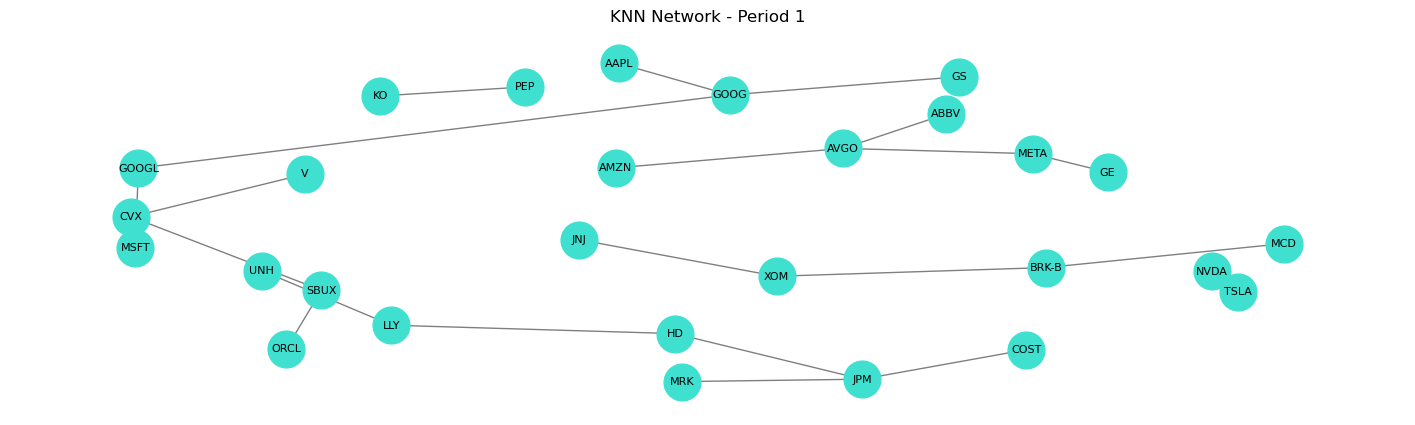

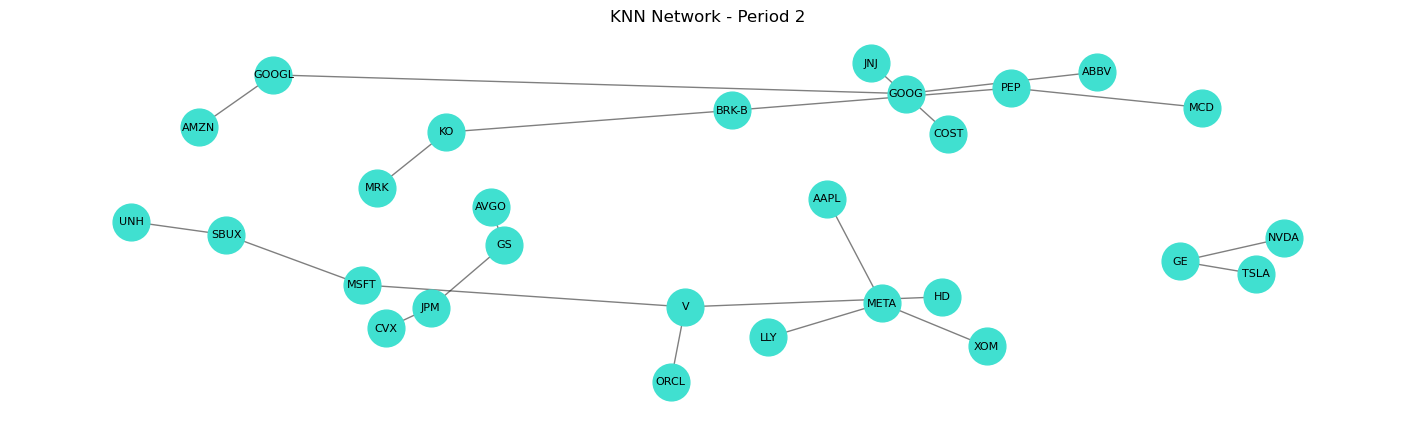

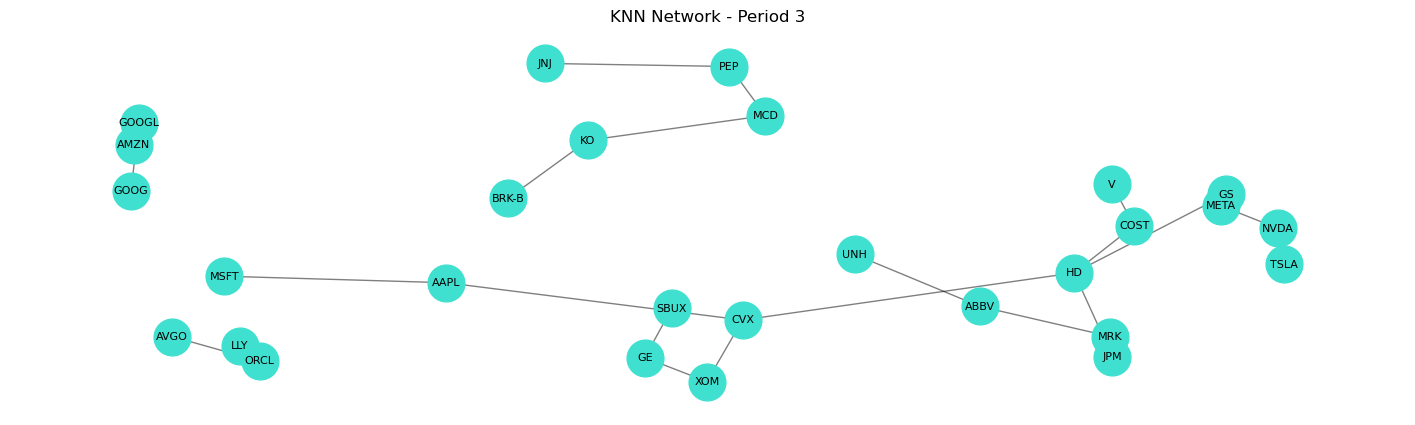

In [ ]:
degrees_knn = pd.DataFrame(index=col_names)

for i, df in enumerate(vols):
    df_T = df.T.fillna(0)  
    
    # initialize and fit KNN model
    knn = NearestNeighbors(n_neighbors=2, metric='euclidean', p=3)
    knn.fit(df_T)  
    distances, indices = knn.kneighbors(df_T)  

    # build the knowledge graph
    G = nx.Graph()

    # add nodes for each stock
    for stock in col_names:
        G.add_node(stock)

    # add edges based on KNN results
    for row_idx, (dist_row, idx_row) in enumerate(zip(distances, indices)):
        stock = col_names[row_idx]
        for j, (dist, idx) in enumerate(zip(dist_row, idx_row)):
            if idx != row_idx:  # avoid self-loops
                neighbor_stock = col_names[idx]
                G.add_edge(stock, neighbor_stock, weight=dist)
    
    # plot the knowledge graph
    plt.figure(figsize=(18, 5))
    pos = nx.spring_layout(G, seed=42)
    nx.draw_networkx_nodes(G, pos, node_size=700, node_color='turquoise')
    nx.draw_networkx_edges(G, pos, width=1, alpha=0.5)
    nx.draw_networkx_labels(G, pos, font_size=8)
    plt.title(f"KNN Network - Period {i+1}")
    plt.axis("off")
    plt.show()

    # compute and store vertex degrees, insert into degrees_knn
    degree_dict = dict(G.degree())
    degrees_ordered = [degree_dict[name] for name in col_names]
    degrees_knn[f"Period {i+1} Degrees"] = degrees_ordered

In [45]:
degrees_knn

,Period 1 Degrees,Period 2 Degrees,Period 3 Degrees
Ticker,,,
AAPL,1,1,2
NVDA,1,1,2
MSFT,1,2,1
AMZN,1,1,1
META,2,3,1
GOOGL,2,2,2
TSLA,1,1,1
AVGO,3,1,1
GOOG,3,2,1


In [46]:
degrees_knn_all = (degrees_knn['Period 1 Degrees'].sum(), degrees_knn['Period 2 Degrees'].sum(), degrees_knn['Period 3 Degrees'].sum())
degrees_knn_all

(42, 42, 44)

In [47]:
# Handshaking lemma
edge_count_knn = pd.DataFrame({
    'Period 1': degrees_knn['Period 1 Degrees'].sum() / 2,
    'Period 2': degrees_knn['Period 2 Degrees'].sum() / 2,
    'Period 3': degrees_knn['Period 3 Degrees'].sum() / 2
    }, index=['Edge Count KNN Graph'])

print(f"The Number of Edges in each Period's KNN Graph:")
edge_count_knn 

The Number of Edges in each Period's KNN Graph:


,Period 1,Period 2,Period 3
Edge Count KNN Graph,21.0,21.0,22.0


# Summary

### GraphicalLasso Knowledge Graphs
- Ironically, the density of the knowledge graphs were higher in the pre- and post-COVID periods. The reason for this is that during the covid drop, much of the market's movement was driven by a single factos(COVID). When we apply GraphicalLasso, we find that the conditional correlation that remained after removing the large COVID shock was actually lower. Applying GraphicalLasso zeroed out many pairwise edges leaving us with a sparser network than pre- and post-covid drops. 
- In calmer times, the basket of stocks were driven by a wider variety of sector/company specific factors. When removing the general market factor, we were left with many "direct" connections among the stocks giving us a denser network. 
- Total Edge Counts in the 3 periods, respectively: 148, 50, 154
- Overall, while unconditional correlations were higher during COVID, conditional dependencies were actually smaller, which is why after "removing" the single dominant shock driving the entire market, we observe a sparser graph. 


### GraphicalLassoCV Knowledge Graphs
- Prior to applying GraphicalLassoCV, I applied PCA onto the standardized volatility data for each period, reducing the dimensionality of the data to retain 99.5% of the variance. 
- Then applied GraphicalLassoCV, giving a range for alpha paramter. 
- GraphicalLassoCV helps tune the regularization parameter automatically. After using GraphicalLassoCV among the principal components, I transform back into the original stock space, including a threshold to determine whether an edge is warranted. 
- The resulting density of the knowledge graphs were similar to GraphicalLasso, but final edge counts differed: 
- Period 1, 2, 3, respectively: 150, 21, 116
- Pre- and Post-Covid periods were fairly similar, with during-covid period being affected most. This significant decrease during the covid drop is explained by the application of PCA and using Cross Validation to find an optimal alpha parameter. When not using CV, the alpha parameter may not have been optimized for the COVID window's data. By applying PCA, we compress the variance into fewer principal components, and then using CV, many of the smaller conditional relationships are minimized, which is evident after transforming back to the original space with fewer edges. 

### Clustering Analysis(KNN)
- KNN was applied to build a network that uses distance to visualize which stocks volatility patterns were closest together through the 3 periods. 
- Using n_neighbors=2 results in smaller clusters, or chains. Comparing the clusters across all periods reveal how similar relationships in volatility patterns evolved prior to, during, and after the covid drop. Some stocks clustered in period 1 separate into more isolated groups which reflects the dramatic idiosyncratic shifts in volatility that occured for certain sectors/industries under lockdown periods.
- Some stocks remain closely related through the periods, like CVX & XOM(energy stocks), KO & PEP(consumer staples), and Big-Tech stocks. 
- Stocks that have degrees higher than 2 tell you that its volatiltiy pattern is "close" to a larger subset of the basket of stocks. It becomes a "hub" in the KNN graph because its volatility patterns overlap with a large portion of the market. 

